In [1]:
# import lsst.summit.extras

In [2]:
# lsst.summit.__file__

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
from lsst.summit.extras.plotting.psfPlotting import makeAzElPlot, makeTableFromSourceCatalogs,makeFocalPlanePlot, makeEquatorialPlot, addColorbarToAxes
from atmospheric_dispersion_correction import addADC_to_Table
from lsst.obs.lsst import LsstComCam, LsstCam
import matplotlib.pyplot as plt
from ellipticity_util import addFieldCoords_to_Table, makeOCSPlot, read_batoid_table, addOpticalCoords_to_Table, MakeGridMedianPSF, makeTableFromCalexps, statistics_on_moments
# from lsst.ts.aos.analysis import StateFetcher #source .user_setups
from lsst.daf.butler import Butler
import numpy as np
from astropy.table import Table
from astropy.io import ascii

In [20]:
folderout = '/home/v/vittorio/image_quality_shared/imsim/ellipticitymap/figures/'
folderout_table = '/home/v/vittorio/image_quality_shared/imsim/ellipticitymap/tables/'

## set up

In [36]:
selection_index = 2 # 0 for ComCam; 1 for Imsim LSSTCam; 2 for LSSTCam on /repo/main

# if selection_index == 0:
#     #ComCam
#     camera = LsstComCam().getCamera()
#     first_det = 0
#     n_det = 9
#     butler = Butler(
#         "embargo", 
#         collections=["LSSTComCam/nightlyValidation"], 
#         instrument="LSSTComCam"
#     )
if selection_index == 0:
    #ComCam
    camera = LsstComCam().getCamera()
    first_det = 0
    n_det = 189
    butler = Butler(
        "embargo", 
        collections=["LSSTComCam/nightlyValidation"], 
        instrument="LSSTComCam"
    )
    
    dayObs = 20250826 
    seqNum = 34    
    visit_id = int(f"{dayObs}{seqNum:05d}")
    suffix_out = 'nightlyValidation'
    object_to_get = 'icSrc'
    visit_info_to_get = 'postISRCCD.visitInfo'

elif selection_index == 1:
    #Imsim LSSTCam
    camera = LsstCam().getCamera()
    first_det = 90
    n_det = 9 # LSSTCam
    import sys
    sys.path.append("/sdf/data/rubin/shared/image_quality/imsim/notebooks/") #file with convertion between seqnum and collection
    from collection_dictionary_shared import collection_dictionary
    folder = '/sdf/data/rubin/shared/image_quality/imsim/'
    ############Define the butler data configuration and collection (una tantum )
    config = folder+'repo'
    collection_dict = collection_dictionary()
    seqNum = 228
    
    if seqNum >= 188:
        seqnum_base = 7023071700000
    else:
        seqnum_base = 5023071800000
    
    visit_id = seqNum+seqnum_base
    collections = collection_dict[visit_id]
    butler = Butler(config, collections=collections)
    suffix_out = 'ImSim'
    object_to_get = 'icSrc'
    visit_info_to_get = 'postISRCCD'

elif selection_index == 2:
    #LSSTCam
    camera = LsstCam().getCamera()
    first_det = 0
    n_det = 189
    butler = Butler(
        "/repo/main", 
        collections=["u/vittorio/pipetask_output_2025082600083all0"], 
        instrument="LSSTCam"
    )
    
    dayObs = 20250826 
    seqNum = 83
    visit_id = int(f"{dayObs}{seqNum:05d}")
    suffix_out = 'nightlyValidation'
    object_to_get = 'single_visit_star_footprints'
    visit_info_to_get = 'post_isr_image'


## Lettura icSrc

In [37]:
# Questo per le immagini su /repo/main e per i prodotti ottenuti con la nuova pipeline (pre 251002)

icSrcs={}
for i in range(n_det):
    try:
        icSrcs[first_det+i] = butler.get(object_to_get, dataId={"visit":visit_id, "detector":first_det+i})
        print(first_det+i)
    except:
        print('xxx', first_det+i)
        continue
visitInfo = butler.get(visit_info_to_get, dataId={"exposure":visit_id, "detector":(first_det)})
band = visitInfo.getFilter().bandLabel
visitInfo = visitInfo.visitInfo

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
xxx 122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188


In [38]:
visitInfo

VisitInfo(exposureTime=30, darkTime=30.9314, date=2025-08-27T01:20:27.571391910, UT1=nan, ERA=6.1989 rad, boresightRaDec=(291.7273184358, -36.8018661674), boresightAzAlt=(138.5635375583, +81.0113035257), boresightAirmass=1.01241, boresightRotAngle=3.50775 rad, rotType=1, observatory=-30.2446N, -70.7494E  2663, weather=Weather(13.0875, 74375, 4.85), instrumentLabel='LSSTCam', id=2025082600083, focusZ=-2.26891, observationType='acq', scienceProgram='BLOCK-T539', observationReason='infocus_initial_alignment', object='UNKNOWN', hasSimulatedContent=false)

In [39]:
table = makeTableFromSourceCatalogs(icSrcs, visitInfo)

In [40]:
# add atmospheric dispersion correction to the table
# table = addADC_to_Table( table, elevation_angle, filter, pressure=800, temperature=15 )
# TODO: check if the default values are sensible

elevation_angle = visitInfo.boresightAzAlt[1].asDegrees() # elevation angle in degrees
table = addADC_to_Table( table, elevation_angle, band ) # optional pressure and temperature arguments

In [41]:
table = addOpticalCoords_to_Table( table )
table = addFieldCoords_to_Table( table, camera ) #non mi funziona quando uso immagini imsim

In [42]:
table_grid = MakeGridMedianPSF(table, 50, 50, 3)

In [43]:
# Statistics on moments

statistics = statistics_on_moments(table)

ascii.write(statistics, folderout_table+'statistics'+str(visit_id)+'.dat', overwrite=True)

# print('statistics on oc_Ixx: {:8.5f} {:8.5f} {:8.5f}'.format(oc_ixx_mean, oc_ixx_median, oc_ixx_std))
# print('statistics on oc_Iyy: {:8.5f} {:8.5f} {:8.5f}'.format(oc_iyy_mean, oc_iyy_median, oc_iyy_std))
# print('statistics on oc_Ixy: {:8.5f} {:8.5f} {:8.5f}'.format(oc_ixy_mean, oc_ixy_median, oc_ixy_std))
# print('statistics on oc_e1: {:8.5f} {:8.5f} {:8.5f}'.format(oc_e1_mean, oc_e1_median, oc_e1_std))
# print('statistics on oc_e2: {:8.5f} {:8.5f} {:8.5f}'.format(oc_e2_mean, oc_e2_median, oc_e2_std))
# print('statistics on aa_e: {:8.5f} {:8.5f} {:8.5f}'.format(aa_e_mean, aa_e_median, aa_e_std))
# print('statistics on e: {:8.5f} {:8.5f} {:8.5f}'.format(e_mean, e_median, e_std))
# print('statistics on T: {:8.5f} {:8.5f} {:8.5f}'.format(T_mean, T_median, T_std))

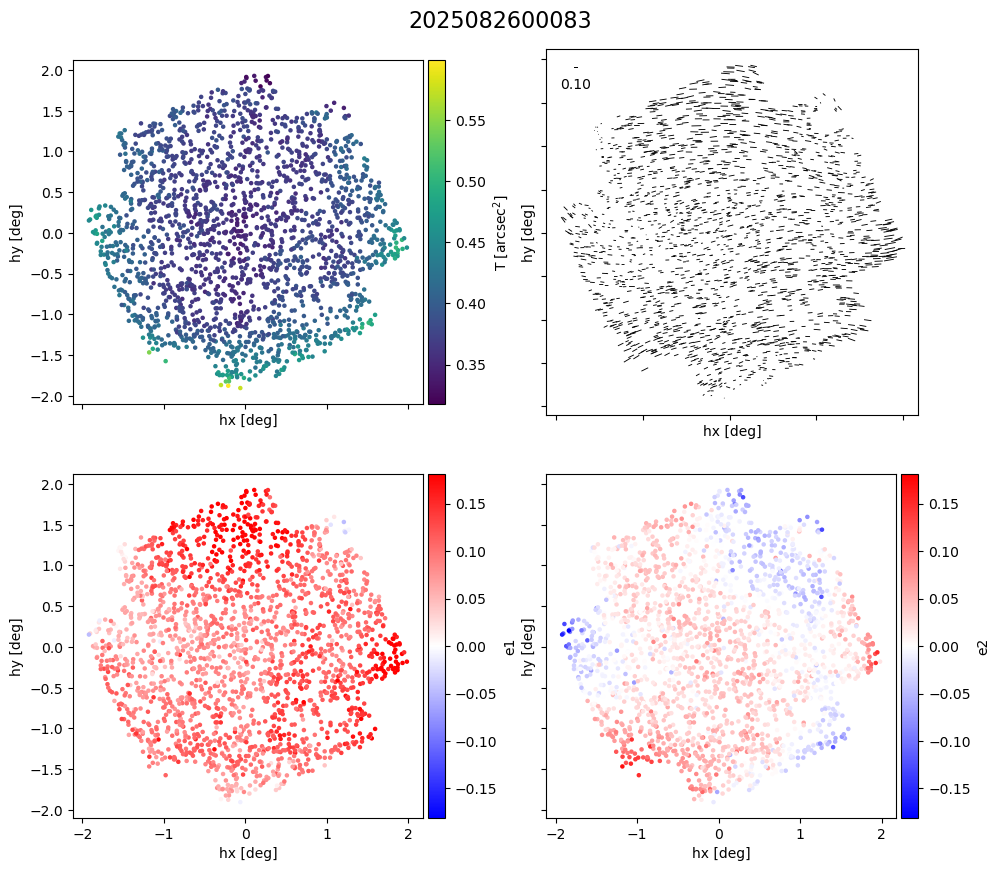

In [44]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 9), sharex=True, sharey=True)
fig.suptitle(visit_id, fontsize=16)
makeOCSPlot(fig, axes, table, camera, autoscale=True, scale_quiver=.75, maxPoints=2000)
plt.show()
fig.savefig(folderout+'Ellipticitymap_OCS_'+suffix_out+'_'+str(visit_id)+'.pdf')

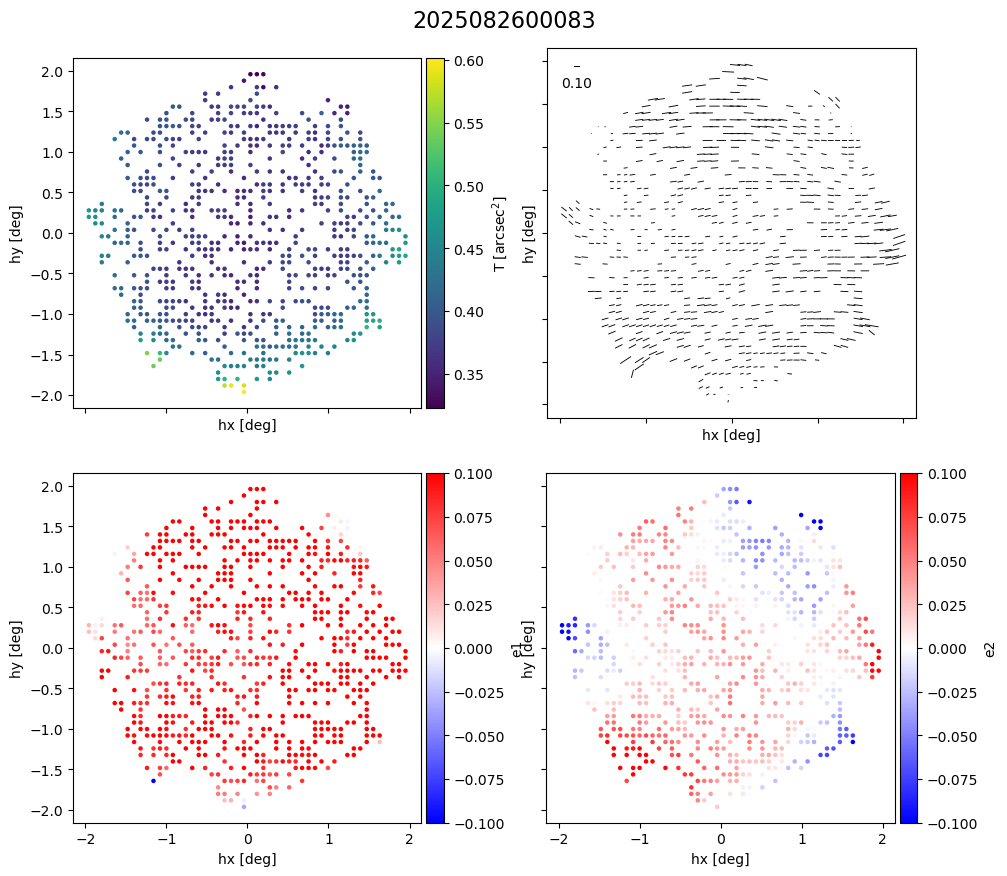

In [45]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 9), sharex=True, sharey=True)
fig.suptitle(visit_id, fontsize=16)
makeOCSPlot(fig, axes, table_grid, camera)
plt.show()
fig.savefig(folderout+'Ellipticitymap_grid_OCS_'+suffix_out+'_'+str(visit_id)+'.pdf')

## Lettura Calexp

In [13]:
calexps = {}
psfs = {}
dets = {}
bkgds = {}
calexp_infos = {}
sourcess = {}
for i in range(n_det):
    try:
        dataId = {'visit': visit_id, 'detector': i}
        calexp = butler.get('calexp', **dataId)
        sources = butler.get('src', dataId)
        psf = calexp.getPsf()
        det = calexp.getDetector()
        bkgd = butler.get('calexpBackground', **dataId)
        calexp_infos.append(calexp.getInfo())

        calexps.append(calexp)
        psfs.append(psf)
        dets.append(det)
        bkgds.append(bkgd)
        sourcess.append(sources)

    except:
        continue
visitInfo = butler.get("postISRCCD.visitInfo", dataId={"exposure":visit_id, "detector":(n_det-1)})

DatasetNotFoundError: Dataset postISRCCD.visitInfo with data ID {instrument: 'LSSTCam', detector: 0, exposure: 7023071700215} could not be found in collections ('pipetask_output/20250611T110726Z',).

In [ ]:
makeTableFromCalexps(calexps, sourcess, psfs, elevation_angle, visitInfo)

In [14]:
table.columns

<TableColumns names=('id','coord_ra','coord_dec','parent','calib_psf_candidate','calib_psf_used','calib_psf_reserved','base_SdssCentroid_x','slot_Centroid_x','base_SdssCentroid_y','slot_Centroid_y','base_SdssCentroid_xErr','slot_Centroid_xErr','base_SdssCentroid_yErr','slot_Centroid_yErr','base_SdssCentroid_flag','base_CircularApertureFlux_flag_badCentroid','base_GaussianFlux_flag_badCentroid','base_PsfFlux_flag_badCentroid','ext_shapeHSM_HsmSourceMoments_flag_badCentroid','slot_Centroid_flag','base_SdssCentroid_flag_edge','base_CircularApertureFlux_flag_badCentroid_edge','base_GaussianFlux_flag_badCentroid_edge','base_PsfFlux_flag_badCentroid_edge','ext_shapeHSM_HsmSourceMoments_flag_badCentroid_edge','slot_Centroid_flag_edge','base_SdssCentroid_flag_noSecondDerivative','base_CircularApertureFlux_flag_badCentroid_noSecondDerivative','base_GaussianFlux_flag_badCentroid_noSecondDerivative','base_PsfFlux_flag_badCentroid_noSecondDerivative','ext_shapeHSM_HsmSourceMoments_flag_badCentroid

## alt/az in mm

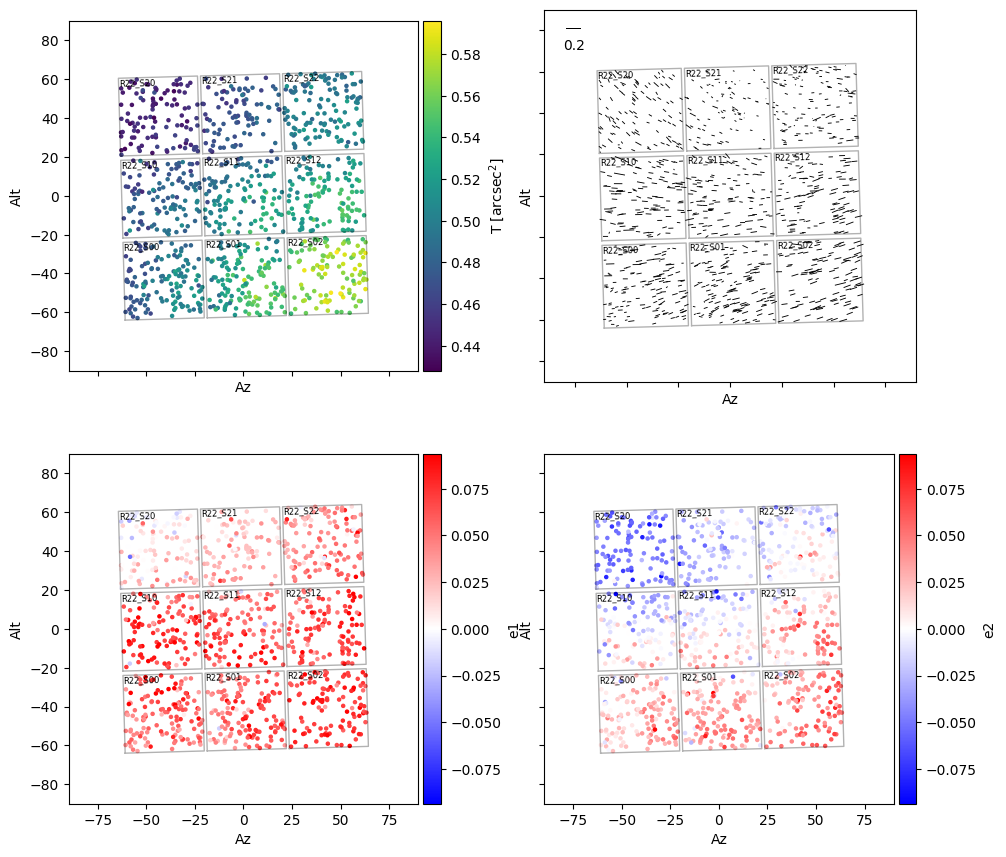

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 9), sharex=True, sharey=True)
makeAzElPlot(fig, axes, table, camera)
plt.show()

In [21]:
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 9), sharex=True, sharey=True)
# makeFocalPlanePlot(fig, axes, table, camera)
# plt.show()

In [22]:
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 9), sharex=True, sharey=True)
# makeEquatorialPlot(fig, axes, table, camera)
# plt.show()

#write output file

In [23]:
import numpy as np

In [22]:
from astropy.io import ascii

In [19]:
outname = 'prova.csv'
# outname = '/home/r/rzanmar/coords_seq%.8d.csv'%seqnum

In [24]:
outname

'prova.csv'

In [25]:
ascii.write(table[ 'oc_x','oc_y','oc_Ixx','oc_Iyy','oc_Ixy', ],outname, format='csv', fast_writer=False, overwrite=True)

In [26]:
table.meta['ocRot']

array([[ 0.99960987, -0.02793032],
       [-0.02793032, -0.99960987]])

# verify mm to field [deg] conversion

In [27]:
hx, hy = table['x'] * 0.2 / 36, table['y'] * 0.2 / 36      # 0.2 arcsec / pix * pix / 10um -> 0.2/36 deg/mm

In [28]:
hx_rot, hy_rot = table['oc_x'] * 0.2 / 36, table['oc_y'] * 0.2 / 36

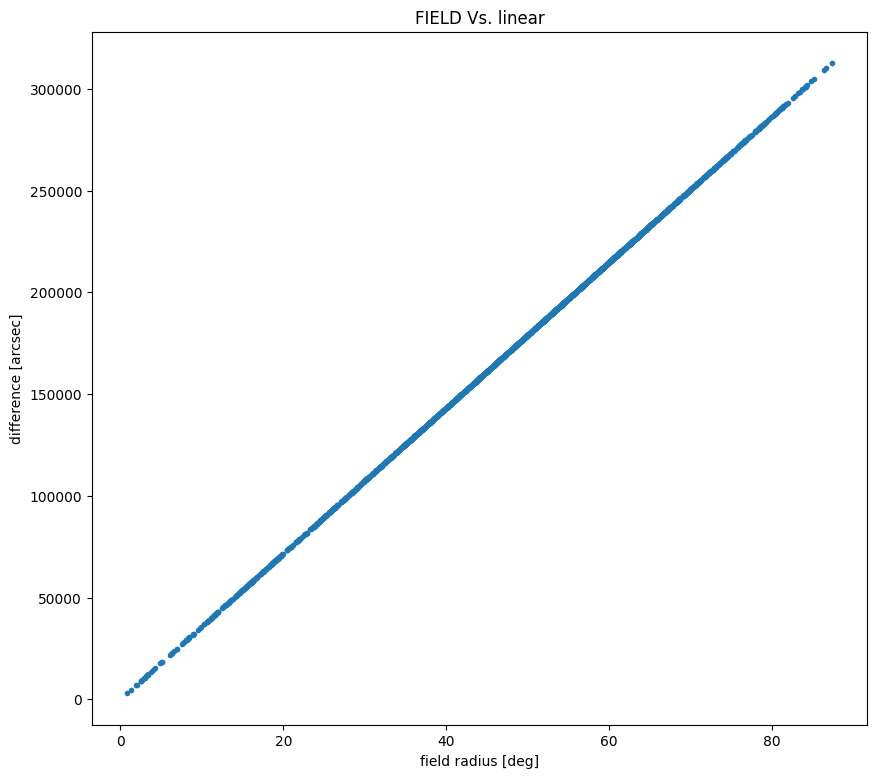

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 9), sharex=True, sharey=True)
plt.plot( np.sqrt( table['oc_x']**2+table['oc_y']**2), np.sqrt( (table['oc_x'] - hx_rot)**2 + (table['oc_y'] - hy_rot)**2)*3600, '.' )
axes.set_xlabel('field radius [deg]')
axes.set_ylabel('difference [arcsec]')
axes.set_title('FIELD Vs. linear')
plt.show()

In [30]:
table.meta['aaRot']

array([[ 0.99960987, -0.02793032],
       [ 0.02793032,  0.99960987]])

In [31]:
table.meta['ocRot']

array([[ 0.99960987, -0.02793032],
       [-0.02793032, -0.99960987]])